# 1. Load packages

The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

or the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [1]:
%run "C:\Users\shiwei\Documents\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"C:\Users\shiwei\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

import pandas as pd

32872


See **functions** in the repository for [AnalysisTool_Chromatin](../../functions/README.md)

In [2]:
# Chromatin_analysis_tools (ATC)
# Get path for the py containing functions
import os
import sys
import importlib
module_path =r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin'
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import relevant modules
import gene_selection 
importlib.reload(gene_selection)
import gene_to_loci
importlib.reload(gene_to_loci)
import gene_activity
importlib.reload(gene_activity)
import loci_1d_features
importlib.reload(loci_1d_features)  

import atac_to_loci
importlib.reload(atac_to_loci)

<module 'atac_to_loci' from 'C:\\Users\\shiwei\\Documents\\AnalysisTool_Chromatin\\atac_to_loci.py'>

In [3]:
import seaborn as sns
import scanpy as sc

## 1.1 Define output folder

In [4]:
output_main_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v2\AB_compartment_th_zero'
output_analysis_folder = os.path.join(output_main_folder, 'analysis')
output_figure_folder = os.path.join(output_main_folder, 'figures')

make_output_folder = True

if make_output_folder and not os.path.exists(output_analysis_folder):
    os.makedirs(output_analysis_folder)
    print(f'Generating analysis folder: {output_analysis_folder}.')
elif os.path.exists(output_analysis_folder):
    print(f'Use existing analysis folder: {output_analysis_folder}.')
    
if make_output_folder and not os.path.exists(output_figure_folder):
    os.makedirs(output_figure_folder)
    print(f'Generating figure folder: {output_figure_folder}.')
elif os.path.exists(output_figure_folder):
    print(f'Use existing figure folder: {output_figure_folder}.')


Use existing analysis folder: L:\Shiwei\Figures\MOp_draft_2023_v2\AB_compartment_th_zero\analysis.
Use existing figure folder: L:\Shiwei\Figures\MOp_draft_2023_v2\AB_compartment_th_zero\figures.


## 1.2 setting up plotting parameters

In [5]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

import matplotlib
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rc('font', family='serif')
plt.rc('font', serif='Arial')


# Other required plotting parameters
_dpi = 300
_font_size = 7.5
_page_width = 5.5

from ImageAnalysis3.figure_tools import _double_col_width, _single_col_width, _ticklabel_size,_ticklabel_width

import seaborn as sns
sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})   

In [6]:
# cell labels from RNA-MERFISH and celltype prediction
selected_cell_labels = ['L2/3 IT','L4/5 IT','L5 IT','L6 IT','L5 ET','L5/6 NP','L6 CT','L6b',
                           'Sst','Pvalb','Lamp5','Sncg','Vip',
                           'Astro','Oligo','OPC','Micro','Endo','VLMC','SMC','Peri', 
                           #'other',
                          ]
# cell palette from RNA-MERFISH UMAP and stats
celltype_palette = {'Astro':'lightcoral', 
                    'Endo':'skyblue', 
                    'L2/3 IT':'gold', 
                    'L4/5 IT':'darkorange', 
                    'L5 ET':'mediumseagreen', 
                    'L5 IT':'aqua',
                    'L5/6 NP':'darkgreen',
                    'L6 CT':'brown',
                    'L6 IT':'magenta',
                    'L6b':'blue', 
                    'Lamp5':'orange', 
                    'Micro':'peachpuff',
                    'OPC':'thistle', 
                    'Oligo':'darkviolet',
                    'Peri':'sandybrown',
                    'Pvalb':'springgreen',
                    'SMC':'rosybrown',
                    'Sncg':'darkkhaki',
                    'Sst':'steelblue', 
                    'VLMC':'saddlebrown', 
                    'Vip':'red',
                    'other':'slategray'}


In [7]:
# this is the plotting order noted based on the snRNA transcriptional acitivty;
# we'd use this for all the graphs in this notebook
# use the snRNA data below (# section 3.1.1) if needs to re-calculate
sorted_cellplot_order = ['Micro', 'Oligo', 'Endo', 'OPC', 'Astro', 'Vip', 'Lamp5',
                  'L5/6 NP', 'Sst', 'Sncg', 'Pvalb', 'L4/5 IT', 'L6 CT',
                  'L6 IT', 'L6b', 'L2/3 IT', 'L5 IT', 'L5 ET']

# 2. Load codebook

## Codebook

Example of [codebook](../../postanalysis/0_locus_annotation/resources/MERFISH_loci_adjacent_genes_tss_more_res.csv)

In [8]:
# load codebook
# L drive is Crick Pu_SSD_0
codebook_save_folder=r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin\resources'

# Load sorted codebook (allows direct matrix slicing) with cell type info
# Load codebook (then sort to allow direct matrix slicing) with cell type info

codebook_fname = os.path.join(codebook_save_folder,'MERFISH_loci_adjacent_genes_tss_more_res.csv')
codebook_df = pd.read_csv (codebook_fname, index_col=0)

# sort df temporailiy so matrix can be sliced by df order directly
codebook_df = loci_1d_features.sort_loci_df_by_chr_order (codebook_df)

codebook_df.head()

,name,id,chr,chr_order,library,dtype,adjacent_genes_0kb_tss,adjacent_genes_10kb_tss,adjacent_genes_50kb_tss,adjacent_genes_100kb_tss,adjacent_genes_200kb_tss,adjacent_genes_500kb_tss,adjacent_genes_1000kb_tss,adjacent_genes_1500kb_tss,adjacent_genes_2000kb_tss
loci_name,,,,,,,,,,,,,,,
chr1_3742742_3759944,1:3742742-3759944,1,1,0,CTP11,combo,intergenic,intergenic,intergenic,Xkr4,Xkr4,Gm18956; Gm7341; Xkr4,Gm18956; Gm2053; Gm6085; Gm6101; Gm6119; Gm734...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...
chr1_6245958_6258969,1:6245958-6258969,2,1,1,CTP11,combo,intergenic,intergenic,4732440D04Rik; Rb1cc1,4732440D04Rik; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Npbwr1; Rb1cc1...,4732440D04Rik; Gm19026; Gm2147; Gm5694; Gm7182...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...
chr1_8740008_8759916,1:8740008-8759916,3,1,2,CTP11,combo,intergenic,intergenic,Gm15452,Gm15452,Gm15452,Gm15452,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm15452;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...
chr1_9627926_9637875,1:9627926-9637875,1,1,3,CTP13,combo,2610203C22Rik,2610203C22Rik,2610203C22Rik,2610203C22Rik; Adhfe1; Gm6161; Mybl1; Rrs1,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm18300;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Cops5; C...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...
chr1_9799472_9811359,1:9799472-9811359,2,1,4,CTP13,combo,Gm6195,Gm6195; Sgk3,Gm6195; Sgk3,1700034P13Rik; Gm6195; Mcmdc2; Mybl1; Sgk3; Vc...,1700034P13Rik; 2610203C22Rik; Gm6195; Mcmdc2; ...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...


## Refgen for gene dist matrix

Example of [refgen](../0_locus_annotation/resources/refgen_df_for_jie.csv)

In [9]:
codebook_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis'
df_refgen_savename = os.path.join(codebook_folder,'refgen_df_for_jie.csv')
df_refgen=pd.read_csv(df_refgen_savename,index_col=0)
df_refgen['chr'] = df_refgen['chr'].apply(lambda x: 'chr'+x)
df_refgen.head()

,name,id,chr,chr_order,library,dtype,loci_name,start,end,hyb,delta,region_id
0,1:3742742-3759944,1,chr1,0,CTP11,combo,chr1_3742742_3759944,3742742,3759944,0,0,1
1,1:6245958-6258969,2,chr1,1,CTP11,combo,chr1_6245958_6258969,6245958,6258969,1,2503216,2
2,1:8740008-8759916,3,chr1,2,CTP11,combo,chr1_8740008_8759916,8740008,8759916,2,4997266,3
3,1:9627926-9637875,1,chr1,3,CTP13,combo,chr1_9627926_9637875,9627926,9637875,3,5885184,4
4,1:9799472-9811359,2,chr1,4,CTP13,combo,chr1_9799472_9811359,9799472,9811359,4,6056730,5


In [10]:
chrom_number = []
for i, row in df_refgen.iterrows():
    if ('X' in row.chr):
        chrom_number.append(20)
    elif ('Y' in row.chr):
        chrom_number.append(21)
    else:
        chrom_number.append(int(row['chr'].split('chr')[-1]))
df_refgen['chrom_number'] = chrom_number
df_refgen.sort_values(['chrom_number','hyb'], inplace=True, ignore_index=True)
df_refgen.head()

,name,id,chr,chr_order,library,dtype,loci_name,start,end,hyb,delta,region_id,chrom_number
0,1:3742742-3759944,1,chr1,0,CTP11,combo,chr1_3742742_3759944,3742742,3759944,0,0,1,1
1,1:6245958-6258969,2,chr1,1,CTP11,combo,chr1_6245958_6258969,6245958,6258969,1,2503216,2,1
2,1:8740008-8759916,3,chr1,2,CTP11,combo,chr1_8740008_8759916,8740008,8759916,2,4997266,3,1
3,1:9627926-9637875,1,chr1,3,CTP13,combo,chr1_9627926_9637875,9627926,9637875,3,5885184,4,1
4,1:9799472-9811359,2,chr1,4,CTP13,combo,chr1_9799472_9811359,9799472,9811359,4,6056730,5,1


In [11]:
from scipy.spatial.distance import squareform, pdist
chr_gene_dist_matrices = {}
for chrom, df_chr in df_refgen.groupby('chr'):
    if 'Y' not in chrom:
        _df = df_chr.sort_values('hyb')
        _delta_values= np.zeros((len(_df),2))
        _delta_values[:,0] = _df.delta.values
        _gene_dist = squareform(pdist(_delta_values))
        chr_gene_dist_matrices[chrom] = _gene_dist

# 3. Load activity density result

Data can be generated from the notebook:

[12_superenhancer_ab_trans_density_between_subclass_analysis](12_superenhancer_ab_trans_density_between_subclass_analysis.ipynb)

In [12]:
_groupby_savename = 'subclass'
norm_compiled_df_savename = os.path.join(output_analysis_folder,f'{_groupby_savename}_SE_AB_ratio_regressed_heatmap_norm_th_zero.csv')
norm_compiled_df = pd.read_csv(norm_compiled_df_savename)

#_groupby_savename = 'neuron'

In [13]:
norm_compiled_df.head()

,loci_name,L2/3 IT,L4/5 IT,L5 IT,L6 IT,L5 ET,L5/6 NP,L6 CT,L6b,Pvalb,Sst,Vip,Lamp5,Sncg,Astro,Oligo,Micro,enhancer_name,Marker_group,Expression_change
0,chr1_9799472_9811359,0.0,-0.040589,0.010178,0.012263,-0.011272,-0.171550,0.025932,-0.196319,-0.314535,0.010613,-0.348040,0.122506,-0.575297,-0.044172,0.004645,0.310149,1:9759317-9835402,L2/3 IT,upregulated
1,chr1_21522568_21534512,0.0,-0.005022,-0.085078,-0.008181,-0.360814,-0.205759,-0.490672,-0.735985,-0.272869,-0.463937,-0.165172,-0.041821,-0.270908,-0.739858,-0.674582,-0.803037,1:21485446-21554433,L2/3 IT,upregulated
2,chr1_62926942_62936078,0.0,-0.066098,0.013718,-0.018990,-0.038071,0.101784,-0.088596,-0.087721,0.046632,0.071399,-0.028664,0.240197,-0.042322,0.209968,0.137750,0.119424,1:62900963-62948089,L2/3 IT,upregulated
3,chr2_135670388_135680581,0.0,0.074915,-0.123171,-0.007143,-0.145754,0.229805,-0.017061,-0.036592,-0.006324,-0.106243,0.327990,0.193271,0.161628,0.051548,-0.115761,-0.165440,2:135658540-135684141,L2/3 IT,upregulated
4,chr3_157181787_157191783,0.0,0.018987,-0.033642,-0.142182,-0.093163,-0.161877,-0.098516,0.182778,-0.177751,0.222176,-0.207876,-0.164298,-0.252623,-0.157928,-0.198435,-0.462625,3:157149588-157216143,L2/3 IT,upregulated


meta NOT subset; don't know how to subset; dropped


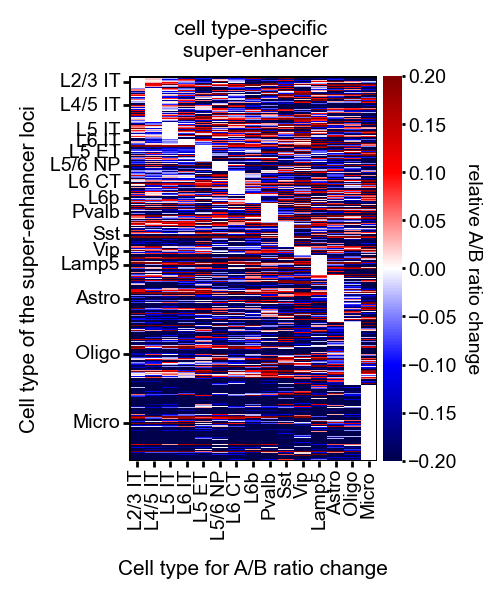

meta NOT subset; don't know how to subset; dropped


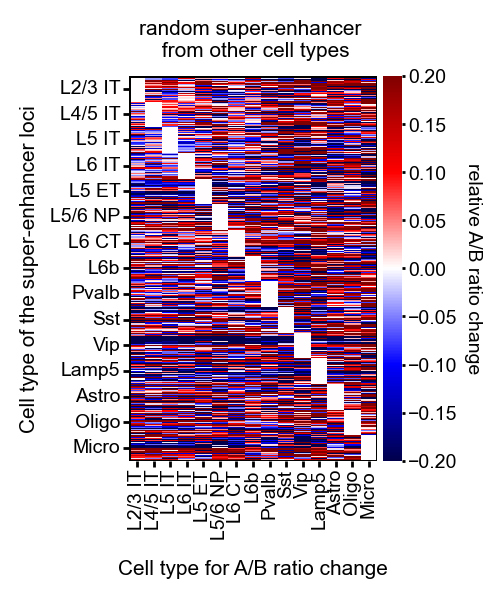

In [14]:
%matplotlib inline

#plt.style.use('dark_background')
#plt.style.use('default')
sorted_group_order = ['L2/3 IT', 'L4/5 IT', 'L5 IT', 'L6 IT', 
                      'L5 ET','L5/6 NP', 'L6 CT', 'L6b',
                      'Pvalb','Sst','Vip','Lamp5', #'Sncg',
                      'Astro','Oligo','Micro']

for _dir in ['upregulated','random_control']:
    
    fig, ax = plt.subplots(1, 1, figsize=(_page_width/2.85, _page_width/2.2) , dpi=200, sharex=True, sharey=True)
    sub_compiled_df = norm_compiled_df[norm_compiled_df['Expression_change']==_dir]
    sub_compiled_df = sub_compiled_df[sub_compiled_df['Marker_group'].isin(sorted_group_order)]
    
    mat_df = sub_compiled_df[sorted_group_order]
    mat_plot = mat_df.to_numpy()
    #mat_df = np.log2(mat_df)

    sns.heatmap(mat_df,vmin=-0.2, vmax=0.2, cmap='seismic', 
                ax=ax, cbar_kws={'label':'A/B ratio fold change', "pad": 0.02})
    #_im = ax.imshow(SE_ratio_mat, vmin=0.99, vmax=1.05, cmap='viridis')
    #vmin, vmax = 0.8, 1.25


    # xticks
    ax.set_xticks(ticks = np.arange(len(mat_df.columns))+0.5)
    ax.set_xticklabels(labels = mat_df.columns,fontsize=_font_size-0.5,
               rotation=90)

    # y ticks
    group_plot = sub_compiled_df.groupby(['Marker_group'],sort=False).size().index
    group_nums = np.array(sub_compiled_df.groupby(['Marker_group'],sort=False).size().tolist())
    group_edges = np.cumsum(group_nums)
    yticks = (group_edges[1:] + group_edges[:-1])/2
    yticks = np.insert(yticks,0, int(group_nums[0]/2))
    yticks=[(_t-0.5) for _t in yticks]
    ax.set_yticks(ticks = yticks)
    ytick_labels  = [f'{_l}' for _l in group_plot]
    ax.set_yticklabels(labels = ytick_labels, fontsize=_font_size-1,
               rotation=0)
    
    ax.tick_params('x', labelsize=_font_size-0.5, 
                    #width=_ticklabel_width, 
                   length=_ticklabel_size,
                    labeltop=False,
                    pad=1, )
    ax.tick_params('y', labelsize=_font_size-0.5, 
                    #width=_ticklabel_width, 
                   length=_ticklabel_size,
                    #labeltop=False,
                    pad=1, )
    ax.figure.axes[-1].tick_params(axis='y', length=1, pad=1, labelsize=_font_size-0.5,)
    ax.figure.axes[-1].set_ylabel('relative A/B ratio change', fontsize=_font_size-0.5, rotation=270, labelpad=9)

    ax.axhline(y=0, color='k',linewidth=1)
    ax.axhline(y=mat_plot.shape[0], color='k',linewidth=1)
    ax.axvline(x=0, color='k',linewidth=1)
    ax.axvline(x=mat_plot.shape[1], color='k',linewidth=1)

    
    ax.set_title(f'{_dir} Marker genes', fontsize=_font_size,pad=7)
    ax.set_xlabel('Cell type for A/B ratio change', fontsize=_font_size,labelpad=7)
    ax.set_ylabel('Cell type of the DE gene loci', fontsize=_font_size)
    ax.axhline(y=0, color='k',linewidth=1)
    ax.axhline(y=mat_plot.shape[0], color='k',linewidth=1)
    ax.axvline(x=0, color='k',linewidth=1)
    ax.axvline(x=mat_plot.shape[1], color='k',linewidth=1)
    
    if _dir == 'upregulated':
        ax.set_title(f'cell type-specific \n super-enhancer', fontsize=_font_size,pad=7)
    else:
        ax.set_title(f'random super-enhancer \n from other cell types', fontsize=_font_size,pad=7)
        
    ax.set_xlabel('Cell type for A/B ratio change', fontsize=_font_size,labelpad=7)
    ax.set_ylabel('Cell type of the super-enhancer loci', fontsize=_font_size)
    
    plt.savefig(os.path.join(output_figure_folder,f'SE_{_groupby_savename}_{_dir}_AB_density_change_heatmap_th_zero.pdf'),
                transparent=True, bbox_inches='tight', pad_inches=0.2, dpi=300)

    plt.show()

## Reduce loci for each marker group to its median

C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_32872\2987149215.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mat_df = sub_compiled_df.groupby(['Marker_group'],sort=False).median()[sorted_group_order]
meta NOT subset; don't know how to subset; dropped
C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_32872\2987149215.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mat_df = sub_compiled_df.groupby(['Marker_group'],sort=False).median()[sorted_group_order]
meta NOT subset; don't know how to subset; dropped


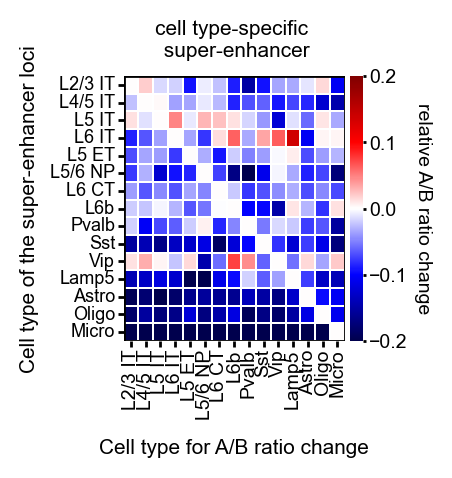

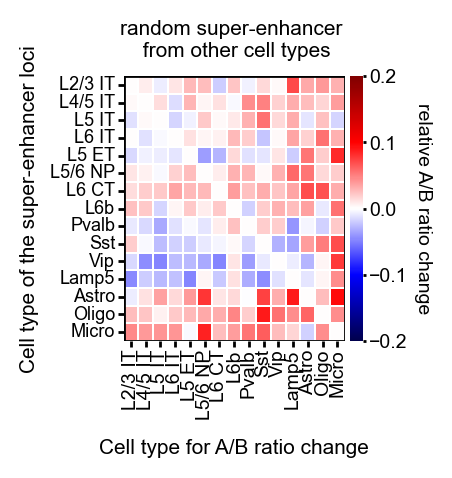

In [15]:
%matplotlib inline


#sns.set(font_scale=1)

for _dir in ['upregulated','random_control']:
    fig, ax = plt.subplots(1, 1, figsize=(_page_width/3.2, _page_width/3.2) , dpi=200, sharex=True, sharey=True)
    
    sub_compiled_df = norm_compiled_df[norm_compiled_df['Expression_change']==_dir]
    sub_compiled_df = sub_compiled_df[sub_compiled_df['Marker_group'].isin(sorted_group_order)]
    mat_df = sub_compiled_df.groupby(['Marker_group'],sort=False).median()[sorted_group_order]
    mat_plot = mat_df.to_numpy()
    #mat_df = np.log2(mat_df)

    sns.heatmap(mat_df,vmin=-0.2, vmax=0.2, cmap='seismic', 
                ax=ax, cbar_kws={'label':'A/B ratio fold change', "pad": 0.02}, linewidth=0.05)

    # xticks
    ax.set_xticks(ticks = np.arange(len(mat_df.columns))+0.5)
    ax.set_xticklabels(labels = mat_df.columns,fontsize=_font_size-1,
               rotation=90)

    
    ax.tick_params('x', labelsize=_font_size-0.5, 
                    #width=_ticklabel_width, 
                   length=_ticklabel_size,
                    labeltop=False,
                    pad=1, )
    ax.tick_params('y', labelsize=_font_size-0.5, 
                    #width=_ticklabel_width, 
                   length=_ticklabel_size,
                    #labeltop=False,
                    pad=1, )
    ax.figure.axes[-1].tick_params(axis='y', length=1, pad=1, labelsize=_font_size-0.5,)
    ax.figure.axes[-1].set_ylabel('relative A/B ratio change', fontsize=_font_size-0.5, rotation=270, labelpad=9)
    
    # y ticks
    group_plot = sub_compiled_df.groupby(['Marker_group'],sort=False).size().index
    ax.set_yticks(ticks = np.arange(len(group_plot))+0.5)
    ytick_labels  = group_plot
    ax.set_yticklabels(labels = ytick_labels,fontsize=_font_size-1,
               rotation=0)

    ax.axhline(y=0, color='k',linewidth=1)
    ax.axhline(y=mat_plot.shape[0], color='k',linewidth=1)
    ax.axvline(x=0, color='k',linewidth=1)
    ax.axvline(x=mat_plot.shape[1], color='k',linewidth=1)

    
    if _dir == 'upregulated':
        ax.set_title(f'cell type-specific \n super-enhancer', fontsize=_font_size,pad=7)
    else:
        ax.set_title(f'random super-enhancer \n from other cell types', fontsize=_font_size,pad=7)

    ax.set_xlabel('Cell type for A/B ratio change', fontsize=_font_size,labelpad=7)
    ax.set_ylabel('Cell type of the super-enhancer loci', fontsize=_font_size)
    
    plt.savefig(os.path.join(output_figure_folder,f'SE_{_groupby_savename}_{_dir}_AB_density_change_heatmap_th_zero_REDUCED.pdf'),
                transparent=True, bbox_inches='tight', pad_inches=0.2, dpi=300)



## Stats for heatmap (all loci)

In [43]:
%matplotlib inline
from scipy.stats import mannwhitneyu
import statsmodels.stats.multitest as multitest

#plt.style.use('dark_background')
#plt.style.use('default')
sorted_group_order = ['L2/3 IT', 'L4/5 IT', 'L5 IT', 'L6 IT', 
                      'L5 ET','L5/6 NP', 'L6 CT', 'L6b',
                      'Pvalb','Sst','Vip','Lamp5', #'Sncg',
                      'Astro','Oligo','Micro']

stats_group_dict = {}
for _marker_group in sorted_group_order:
    _marker_df = norm_compiled_df[norm_compiled_df['Marker_group']==_marker_group]
    
    stats_groups = []
    for _dir in ['upregulated','random_control']:
        sub_marker_df = _marker_df[_marker_df['Expression_change']==_dir]
        sub_marker_vals = sub_marker_df[[g for g in sorted_group_order if g!=_marker_group]] # remove itself
        sub_marker_vals = sub_marker_vals.to_numpy().flatten()
        sub_marker_vals = sub_marker_vals[np.isfinite(sub_marker_vals)]
        stats_groups.append(sub_marker_vals)
    p = mannwhitneyu(stats_groups[0],stats_groups[1], alternative="less",)[1]
    stats_group_dict[_marker_group] = p
        

adj_test, adj_pvals = multitest.fdrcorrection(list(stats_group_dict.values()), alpha=0.05, method='indep', is_sorted=False)
adj_pvals

array([2.02370789e-005, 6.31390166e-018, 8.06534281e-002, 3.10480164e-001,
       2.55758916e-003, 1.09028643e-009, 2.34815109e-021, 1.23121638e-005,
       1.29275027e-008, 3.12490760e-022, 8.71974325e-001, 3.19478454e-012,
       1.99674827e-093, 4.45633301e-100, 8.42432628e-202])